# Model Testing
This notebook tests the models created in "Model Training".

## Imports


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft, istft
import tensorflow as tf
from ipywidgets import interact
from code.stftprocessing import StftDataset
from code.dsvisual import DatasetVisualizer
from tqdm import tqdm
import datetime


2023-04-11 15:13:07.195826: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Load the model
Load the model stored at the _model_path_.

In [2]:
model_path = "model/model-28-03-2023"
new_model_path = "model/model-29-03-h1401-p2941361"

In [3]:
model = tf.keras.models.load_model(model_path)
new_model = tf.keras.models.load_model(new_model_path)

2023-04-11 15:13:19.487033: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-11 15:13:19.490361: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-04-11 15:13:19.539306: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-11 15:13:19.539577: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: NVIDIA GeForce GTX 970 computeCapability: 5.2
coreClock: 1.253GHz coreCount: 13 deviceMemorySize: 3.93GiB deviceMemoryBandwidth: 208.91GiB/s
2023-04-11 15:13:19.539611: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-04-11 15:13:19.753985: I tensorflow/stream_executor/platform/def

## Processing input to the model
The model takes STFT amplitude data.

Write a function that processes a waveform so that it is usable by the model.

This function can then denoise a given waveform directly without preprocessing it into STFT.

In [4]:
def denoise_waveform(waveform, model=model, fs = 0.2):
    # process into STFT
    f,t, result_stft = stft(waveform, fs =fs)

    # get the amplitude
    amp = np.absolute(result_stft)
    phase = np.angle(result_stft)
    # reshape for model
    amp_reshaped = amp.reshape((1, amp.shape[0], amp.shape[1]))
    
    # model predict
    result = model.predict(amp_reshaped)
    
    # process data from STFT into time domain form
    t, signal = istft(result*np.exp(1j*phase), fs = fs)
    signal = signal.reshape(signal.shape[1])
    return signal

## Load the data
Load the time domain waveform data.

In [5]:
data_folder = "data/q3/"


In [6]:
waveforms = np.load(data_folder + "full_waveform_data.npy")
num_waveforms = waveforms.shape[0]

## Display an example waveform
The seismic data of the chosen quality level is stored in the waveforms array.

Display a randomly chosen example waveform from it.

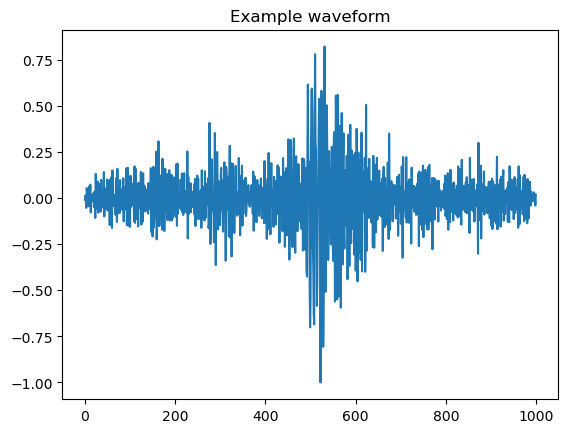

In [15]:
example_index = int(np.random.rand()*num_waveforms)
test_waveform = waveforms[example_index]


plt.plot(test_waveform)
plt.title("Example waveform")
plt.show()

In [17]:
denoised_waveform = denoise_waveform(test_waveform)

2023-04-11 15:17:46.549293: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-04-11 15:17:46.638805: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3593590000 Hz
2023-04-11 15:17:47.008835: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


In [18]:
denoised_waveform.shape

(1024,)

In [45]:
def plot_denoise(index):
    
    # define an array to map the waveforms to (5s sample space)
    time = np.linspace(0, 5000, num = 1000, endpoint=False)
    
    current_waveform = waveforms[index]
    denoised_waveform = denoise_waveform(current_waveform)
    
    fig, [ax1, ax2] = plt.subplots(1,2)
    fig.set_size_inches((12,8))
    
    # ax 1 plot: original and denoised
    ax1.plot(time, current_waveform)
    ax1.plot(time, denoised_waveform[:1000], alpha=0.7)
    ax1.set_title('Original and denoised', fontsize=15)
    ax1.set_xlabel('Time [sec]', fontsize=15)
    ax1.set_ylabel('z-displacement [no unit]', fontsize=15)
    # ax 2 plot: noise difference
    # the denoised waveform result has a shape of (1024,)
    ax2.plot(time, current_waveform - denoised_waveform[:1000])
    
    ax2.set_title('Difference between original and denoised', fontsize=15)
    ax2.set_xlabel('Time [sec]', fontsize=15)
    plt.show()

In [46]:
interact(plot_denoise, index=(0,num_waveforms, 1))

interactive(children=(IntSlider(value=80, description='index', max=160), Output()), _dom_classes=('widget-inte…

<function __main__.plot_denoise(index)>

## Compare two models
Compare the big model with 2,941,361 parameters with the smaller one

In [58]:
def plot_denoise_both(index):
    current_waveform = waveforms[index]
    denoised_waveform = denoise_waveform(current_waveform, model=model)
    denoised_waveform_model2 = denoise_waveform(current_waveform, model=new_model)
    
    fig, [ax1, ax2] = plt.subplots(1,2)
    fig.set_size_inches((8,6))
    ax1.plot(current_waveform)
    ax1.plot(denoised_waveform, alpha=0.4)
    ax1.plot(denoised_waveform_model2, alpha=0.4)

    # ax2.plot(current_waveform)
    ax2.plot(denoised_waveform, alpha=0.4)

    ax2.plot(denoised_waveform_model2, alpha=0.4)
    plt.show()

In [59]:
interact(plot_denoise_both, index=(0,num_waveforms, 1))

interactive(children=(IntSlider(value=80, description='index', max=160), Output()), _dom_classes=('widget-inte…

<function __main__.plot_denoise_both(index)>

# Quality assessment of denoising
There is no real signal to be checked against, a simple error calculation based on difference is therefore not suitable.

An alternative measure is to check how much a distribution is Gaussian.

In [79]:
def plot_difference_dist(index):
    current_waveform = waveforms[index]
    denoised_waveform = denoise_waveform(current_waveform, model=model)
    difference = current_waveform - denoised_waveform[:1000]
    
    fig, [ax1, ax2, ax3] = plt.subplots(1,3)
    fig.set_size_inches((8,6))
    ax1.plot(current_waveform)
    ax1.plot(denoised_waveform, alpha=0.4)
    ax1.set_title("Original and denoised")

    # ax2.plot(current_waveform)
    ax2.plot(difference)
    ax2.set_title("Residual noise")

    ax3.hist(difference, bins=60)
    ax3.set_title("Distribution of residual noise")
    
    plt.show()

In [80]:
interact(plot_difference_dist, index=(0,num_waveforms-1, 1))

interactive(children=(IntSlider(value=79, description='index', max=159), Output()), _dom_classes=('widget-inte…

<function __main__.plot_difference_dist(index)>

### Discussion
The difference in the distribution seems to be negligible from visual inspection. 

The difference will likely be in the order a few percentage points.

The difference in signal will be due to high values to either side of zero. This means the property of being "long-tailed" will be releveant.

## Quality assessment using variance
The variance of the distribution should be close.

In [85]:
np.sqrt(np.var(test_waveform))

0.1680796132755583

(array([  2.,   0.,  11.,  14.,  88., 801.,  82.,  15.,   9.,   2.]),
 array([-0.98963597, -0.80819068, -0.62674539, -0.4453001 , -0.26385481,
        -0.08240953,  0.09903576,  0.28048105,  0.46192634,  0.64337163,
         0.82481692]),
 <BarContainer object of 10 artists>)

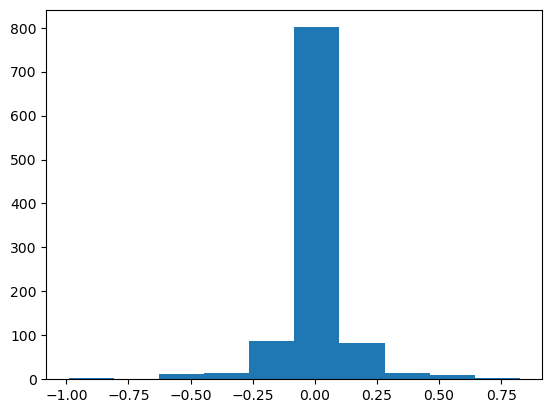

In [86]:
plt.hist(denoise_waveform(test_waveform))

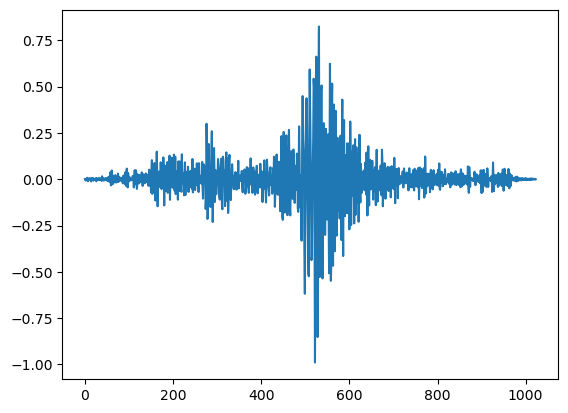

In [87]:
plt.plot(denoise_waveform(test_waveform))

Still to do:
using variance of segments in a meaningful way

## Quality assessment using mean of segments
Here the idea is to split up the waveform into several time segments.

Then taking the mean of the absolute values on each segment and comparing highest to lowest gives a good estimate of the distribution of the noise.
The goal is to have quality 1 (highest to lowest- 1:1) as best possible value with lower numbers representing 

In [139]:
def assess_quality(waveform, method="segments"):

    denoised_waveform = denoise_waveform(waveform)[:1000]
    
    # calculate the residual noise and split into segments
    num_segments = 5
    residual_noise = denoised_waveform - waveform
    splits = np.split(residual_noise, num_segments)
    
    # calculate the mean of the absolute values
    splits_mean = np.mean(np.abs(splits), axis=1)
    
    ratio = np.min(splits_mean)/np.max(splits_mean)
    
    return ratio

In [140]:
num_waveforms = waveforms.shape[0]
quality_assessment = np.zeros(num_waveforms)

for i in tqdm(range(num_waveforms)):
    ratio = assess_quality(waveforms[i])
    quality_assessment[i] = ratio

100%|█████████████████████████████████████████| 160/160 [00:03<00:00, 49.29it/s]


(array([ 3.,  7., 21., 17., 21., 24., 31., 18., 14.,  4.]),
 array([0.03390162, 0.12447477, 0.21504792, 0.30562108, 0.39619423,
        0.48676738, 0.57734054, 0.66791369, 0.75848685, 0.84906   ,
        0.93963315]),
 <BarContainer object of 10 artists>)

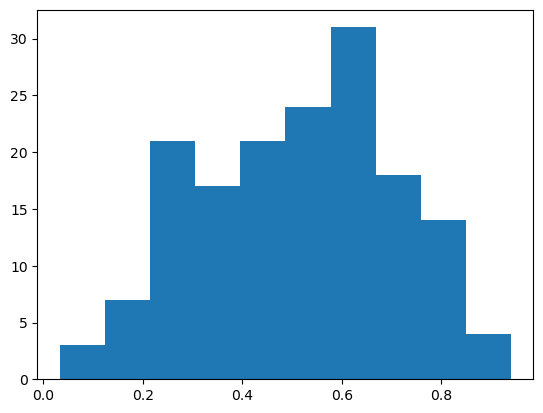

In [141]:
plt.hist(quality_assessment)

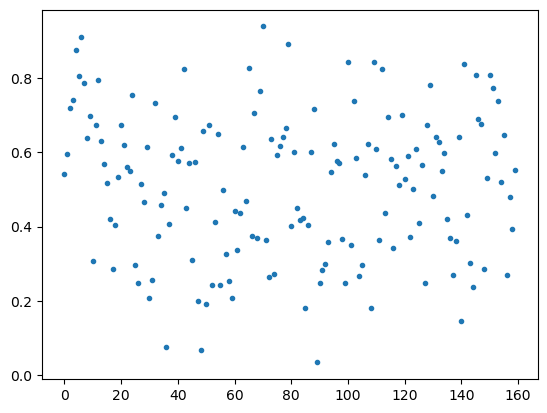

In [142]:
plt.plot(quality_assessment,".")

In [138]:
quality_assessment[153]

0.18192298775101257